In [9]:
import numpy as np
import pdb

from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import random as rnd
from scipy.stats import norm, multivariate_normal
from sklearn.neighbors import KernelDensity as kd

%matplotlib inline
rc('lines', linewidth=3)
rc('font', size=18)
rc('legend', fontsize=18)

In [10]:
# For reproducibility
rng = rnd.RandomState(1083463236)

In [11]:
# mixing proportions: 0.5 and 0.5
# mean0 = mean1 = 0
# sigma1 = 1
# sigma0: parameter of interest

sigma1 = 1
sigma0 = 4

# number of data points
# TODO: run code with n=100000 
n = 10000

## Generate observed data

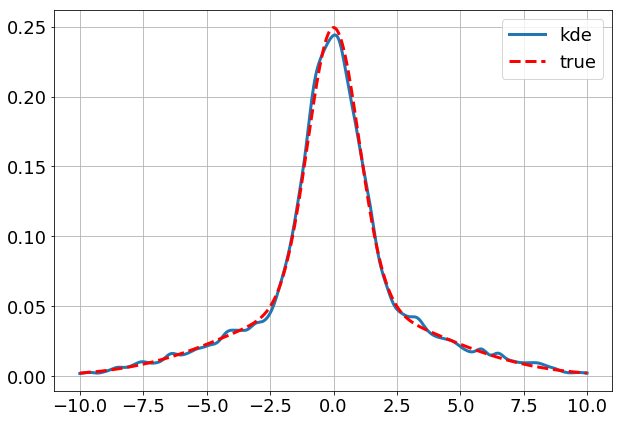

In [12]:
z = rnd.uniform(0,1, n) > 0.5

x = ((z==0)*(rnd.randn(n)*sigma0) + (z==1)*(rnd.randn(n)*sigma1)).reshape(-1,1)

# check
fig = plt.figure(figsize=(10,7))
u = np.arange(-10,10,0.01).reshape(-1,1)

x_density = kd(bandwidth=0.2).fit(x)
x_density_samples = np.exp(x_density.score_samples(u))
plt.plot(u, x_density_samples, label='kde')

px = 0.5*(norm.pdf(u,0,sigma0)+norm.pdf(u,0,sigma1))
plt.plot(u, px, label='true', c='r', linestyle = '--')

plt.legend()
plt.grid()

## NCE objective function 

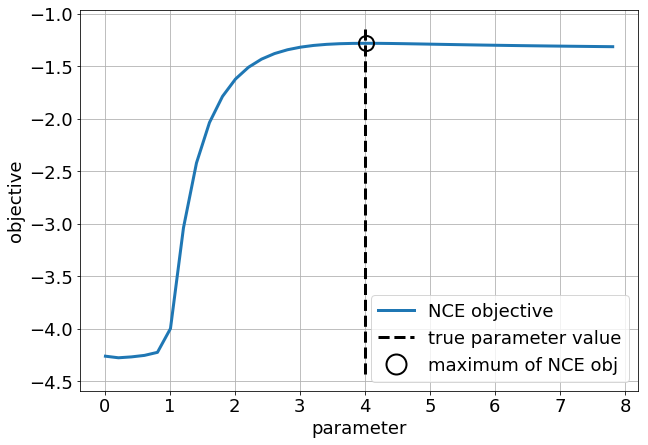

In [28]:
# nu is the ratio of noise to data samples
nu = 1

"""theta = np.arange(0.01, 8, 0.1)"""
theta = np.arange(0.01, 8, 0.2)
# correctly normalised model
pm = lambda u, theta: 0.5*(norm.pdf(u,0,theta)+norm.pdf(u, 0, sigma1))

pn = lambda u: norm.pdf(u,0, sigma0) # noise that matches the larger std

h = lambda u, theta: np.log(pm(u, theta)/pn(u)) # quick hack: generally better to work in log domain!

y = sigma0 * rnd.randn(n*nu)

n_theta = len(theta)
J = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = theta[k]
    J[k] = -np.mean( np.log(1 + nu*np.exp(-h(x,theta_k))) ) - nu* np.mean( np.log(1 + 1/nu*np.exp(h(y,theta_k))) )


fig = plt.figure(figsize=(10,7))

plt.plot(theta,J, label='NCE objective')
plt.plot(sigma0*np.array([1, 1]), plt.get(fig.gca(),'ylim'),'k--', label='true parameter value')

index = np.argmax(J)
plt.plot(theta[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='k', linestyle='none', label='maximum of NCE obj')

plt.xlabel('parameter')
plt.ylabel('objective')

plt.grid()
lgd = plt.legend(loc='best', numpoints=1)
lgd.legendHandles[2]._legmarker.set_markersize(20)

## First lower bound

In [37]:
def compute_J1(J1, theta, q_param):
    # generate 'missing data' using variational q distribution
    zx = rnd.uniform(0, 1, n) < q1(x, q_param)

    # compute expectation for 2nd term of J1
    m = q0(y,q_param)*r0(y,theta, q_param) + q1(y, q_param)*r1(y,theta, q_param)

    # J1 objective
    J1[k] = -np.mean(np.log(1 + nu*1/(r(x, zx, theta, q_param) + eps))) \
            - nu*np.mean( np.log(1 + 1/(nu*m + eps)))


In [38]:
q0 = lambda u, theta:  1 / (1 + (theta/sigma1)*np.exp(-((u**2)/2)*(1/sigma1**2 - 1/theta**2)))
q1 = lambda u, theta: 1 - q0(u, theta) 

phi0 = lambda u, theta:  0.5*norm.pdf(u,0,theta)
phi1 = lambda u, theta:  0.5*norm.pdf(u,0,sigma1)

r0 = lambda u, theta, q_param: phi0(u,theta)/( q0(u, q_param)*pn(u) + eps)
r1 = lambda u, theta, q_param: phi1(u,theta)/( q1(u, q_param)*pn(u) + eps)
r = lambda u, z, theta, q_param: (z==0)*r0(u, theta, q_param) + (z==1)*r1(u, theta, q_param)

J1 = np.zeros(n_theta)
J1_sigma0 = np.zeros(n_theta)

for k in range(n_theta):
    theta_k = theta[k]
    compute_J1(J1, theta_k, theta_k)
    compute_J1(J1_sigma0, theta_k, sigma0)

/afs/inf.ed.ac.uk/user/s17/s1771906/miniconda3/envs/mlp/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


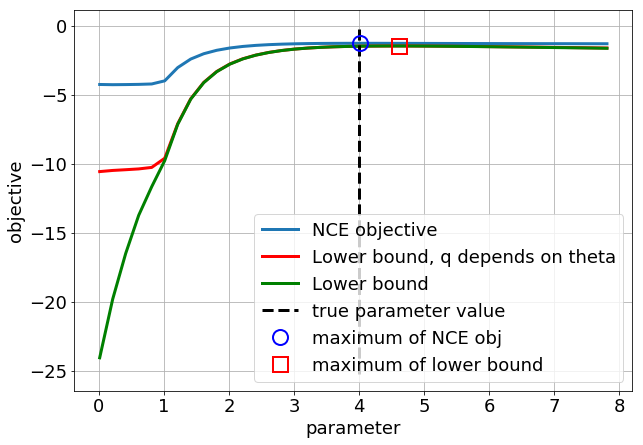

In [41]:
fig = plt.figure(figsize=(10, 7))
plt.plot(theta, J, label='NCE objective')
plt.plot(theta, J1, 'r', label='Lower bound, q depends on theta')
plt.plot(theta, J1_sigma0, 'g', label='Lower bound')

# true param value
plt.plot(sigma0 * np.array([1,1]), plt.get(fig.gca(),'ylim'), 'k--', label='true parameter value')

# maximiser of NCE obj
plt.plot(theta[index],J[index], marker='o', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='b', linestyle='none', label='maximum of NCE obj')

index1 = np.argmax(J1)
# maximiser of lower bound
plt.plot(theta[index1], J1[index1], 'rs', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='r', linestyle='none', label='maximum of lower bound')

"""
plt.plot(theta,Jlower,'g', label='lb w/o importance sampling')
index2 = np.argmax(Jlower)
# maximiser of lower bound (before importance sampling)
plt.plot(theta[index2], Jlower[index2], '^', markersize=15, fillstyle='none', 
         markeredgewidth=2, c='g', linestyle='none', label='max of lb w/o importance sampling')
"""

plt.xlabel('parameter')
plt.ylabel('objective')
plt.legend(loc='lower right', numpoints=1)
plt.grid()